# Project Overview
### Background
Whilst researching possible ideas for this project, the majority of simple use-cases for data science appeared to be focused around business problems such as financial forecasting, churn prediction or channel optimisation. However, as a data analyst already, this is my day job. So I decided to find something instead that mattered to me, and could be applied to benefit society.

The past 10 years have seen an explosion in the phenomena of 'Fake News'. Whilst misinformation and lies have existed for as long as humans have had the ability to talk, the rise of the internet has allowed misinformation to propegate like never before.

Therefore, I wanted to create a model which would be able to 'call out' fake news articles.

### Proposal
The aim of this workbook will be to build a model which classifies a webpage as either real or fake, to a reasonable degree of accurancy.

I think a degree of leniancy should be afforded when talking about accuracy, due to the highly specific nature of this problem.

### Data
Finding quality datasets which classify real and fake news was quite a challenge. However, luckily I was able to identify one such dataset on Kaggle, uploaded by user Hassan Amin. The dataset can be found here: https://www.kaggle.com/hassanamin/textdb3.

I was able to check several of the records that are still available on the web, and can validate the ones I checked seemed correctly labeled.

The dataset covers real and fake news articles, generally centred around American politics and the 2016 election cycle. This will affect which types of articles the model can hope to classify.

### Method
First we will prepare the data. This will not involve much transformation (but I do not consider this important as I generally do this in my day-job), but will include vectorising the text data into a format readable by the model.

Then, we will compare a range of models and select the best one based on the accuracy score.

Finally, we will test the model "in the wild" by webscraping articles from a range of sources I can vouch for as being either real, fake, or questionable.

I thoroughly recommend that the reviewer try a few articles of their own!

In [63]:
# libraries
import numpy as np
import pandas as pd
import itertools
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [65]:
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('news.csv')

In [33]:
df.shape

(6335, 3)

In [3]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
df['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

(6335, 4)
(6335, 4)

 This means Unnamed: 0 is just an index and can be removed


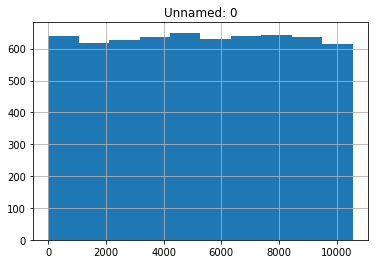

In [5]:
df_distinct = df.drop_duplicates(subset = ['Unnamed: 0'])
print(df.shape)
print(df_distinct.shape)
df.hist(column='Unnamed: 0')
#This means Unnamed: 0 is just an index and can be removed
df = df.drop(['Unnamed: 0'], axis=1)

print('\n This means Unnamed: 0 is just an index and can be removed')

In [6]:
df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [7]:
x = df.isna().sum()
print(x)
print('\n No null values - Nice')

title    0
text     0
label    0
dtype: int64

 No null values - Nice


In [8]:
print(df['title'].str.len().agg(['mean','max','std']))
print('-------------')
print(df['text'].str.len().agg(['mean','max','std']))

mean     65.277664
max     289.000000
std      23.733657
Name: title, dtype: float64
-------------
mean      4707.250355
max     115372.000000
std       5090.956446
Name: text, dtype: float64


In [9]:
#Taking a look at a sample. Quite a lot of text to work with.
df['text'][df.iloc[1]]

1
Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

## Train and define model

In [10]:
# Classes to classify
labels = df.label

In [11]:
# split the data into train and test
x_train,x_test,y_train,y_test=train_test_split(df['text'], labels, test_size=0.25, random_state=7)

In [12]:
# vectorise the text
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(x_train) 
tfidf_test = tfidf_vectorizer.transform(x_test)

The below 2 cells were my previous attempt, but I have left them here for context, please ignore :)

In [70]:
forest = RandomForestClassifier(n_estimators=1000, random_state=0)#forest.fit(tfidf_train,y_train)

y_pred_forest = forest.predict(tfidf_test)

print(classification_report(y_test,y_pred_forest))

              precision    recall  f1-score   support

        FAKE       0.92      0.91      0.91       808
        REAL       0.91      0.91      0.91       776

    accuracy                           0.91      1584
   macro avg       0.91      0.91      0.91      1584
weighted avg       0.91      0.91      0.91      1584



In [72]:
pass_agg_clf = PassiveAggressiveClassifier(max_iter=50, random_state=0)
pass_agg_clf.fit(tfidf_train,y_train)

y_pred_pass = pass_agg_clf.predict(tfidf_test)

print(classification_report(y_test,y_pred_pass))

              precision    recall  f1-score   support

        FAKE       0.93      0.93      0.93       808
        REAL       0.92      0.93      0.92       776

    accuracy                           0.93      1584
   macro avg       0.93      0.93      0.93      1584
weighted avg       0.93      0.93      0.93      1584



### Model selection
Here, we compare the accuracy of different models using a 10-fold cross-validation method, to evaluate each algorithm. I also included a consistent random seed to ensure consistent comparability, however this did throw some warnings.

LR: 0.916017 (0.012824)
CART: 0.825508 (0.016017)
SVM: 0.926751 (0.010898)
FOR: 0.899601 (0.009781)
AGG: 0.940222 (0.008169)


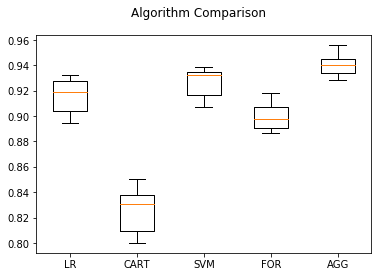

In [97]:
# define models to evaluate
models = []
models.append(('LR', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('FOR', RandomForestClassifier()))
models.append(('AGG', PassiveAggressiveClassifier()))

# evaluate models
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=0, shuffle=True)
    cv_results = model_selection.cross_val_score(model, tfidf_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
    
# boxplot comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

PassiveAggressiveClassifier looks like the best option based on accuracy, so we will use that as our model of choice

In [80]:
pass_agg_clf = PassiveAggressiveClassifier(max_iter=50, random_state=0)
pass_agg_clf.fit(tfidf_train,y_train)

y_pred_pass = pass_agg_clf.predict(tfidf_test)

print(classification_report(y_test,y_pred_pass))

              precision    recall  f1-score   support

        FAKE       0.93      0.93      0.93       808
        REAL       0.92      0.93      0.92       776

    accuracy                           0.93      1584
   macro avg       0.93      0.93      0.93      1584
weighted avg       0.93      0.93      0.93      1584



## Web scraping to test model in the wild!

The below code is rough workings. Which I have included for the benefit of context. It is refactored and changed into a function later on

In [15]:
#url = 'https://www.washingtonpost.com/local/new-poll-finds-9-in-10-native-americans-arent-offended-by-redskins-name/2016/05/18/3ea11cfa-161a-11e6-924d-838753295f9a_story.html'  #Real News
#url = 'https://www.breitbart.com/europe/2020/07/15/bastille-day-battle-antifa-protesters-clash-police-paris/'    #Dubious News
url = 'http://www.thefiscaltimes.com/Columns/2016/01/26/Bernie-Sanders-Says-He-s-Democratic-Socialist-Here-s-What-Means' #Oh dear me...
res = requests.get(url)
html_page = res.content

In [16]:
soup = BeautifulSoup(html_page, 'html.parser')

I used a lot of trial and error with the below cell, to find out which HTML element most reliably identified the body of text. It almost always came from < p > in these articles, so I went with a single search rather than a list

In [17]:
text = soup.find_all(text=True)

set([t.parent.name for t in text])

{'[document]',
 'a',
 'b',
 'body',
 'div',
 'footer',
 'h1',
 'h2',
 'h3',
 'head',
 'header',
 'html',
 'label',
 'li',
 'p',
 'script',
 'span',
 'style',
 'title',
 'ul'}

In [18]:
output = ''
for t in text:
    if t.parent.name == 'p':
        output += '{} '.format(t)

#output

In [19]:
x_new = x_test

In [20]:
for item in x_new.index:
    x_new[item] = output

In [21]:
newvalue = tfidf_vectorizer.transform(x_new)

In [81]:
example = pass_agg_clf.predict(newvalue[0])

In [82]:
example

array(['FAKE'], dtype='<U4')

At this point, it looks good! Not perfect, but functional. Below I structure the model into a callable function, which we can use for trying new articles

In [83]:
def predict_article(url):
    '''
    Takes a url of a webpage, identifies the main body of the text then
    returns whether or not the model thinks it is fake
    Arguments:
        -url: the url of the article to classify.
    Returns:
        -real_or_fake: The model's predicted class
    '''
    url = url
    res = requests.get(url)
    html_page = res.content
    soup = BeautifulSoup(html_page, 'html.parser')
    text = soup.find_all(text=True)
    html = set([t.parent.name for t in text])
    if 'p' not in html:
        return 'No Article Found'
    
    output = ''
    for t in text:
        if t.parent.name == 'p':
            output += '{} '.format(t)
    
    x_new = x_test
    for item in x_new.index:
        x_new[item] = output
    
    newvalue = tfidf_vectorizer.transform(x_new)
    real_or_fake = pass_agg_clf.predict(newvalue[0])
    
    return real_or_fake[0]

Next, we want to test the model against real articles. The how_fake_are_these function does just that

In [100]:
def how_fake_are_these(articles):
    '''
    Takes a list of article urls, then outputs the classification and a % fake score.
    Then prints the results.
    It also deals with invalid datatypes.
    Arguments:
        -artciles: [list] a list of article urls
    '''
    if type(articles) is not list:
        try:
            temp = []
            temp.append(articles)
            articles = temp
        except:
            print('Please provide a list')
    
    fake_rate = []
    
    for i in articles:
        result = predict_article(i)
        if result == 'FAKE':
            fake_rate.append(1)
        else:
            fake_rate.append(0)
        print(result)

    print('{}% fake rate'.format(round((sum(fake_rate) / len(fake_rate)) * 100),1))

Testing based on Google search results for the year 2016, with the topic of the USA election, this is because the training dataset was built from a similar reference the model will not be able to predict, say, a 2020 article about 5G and coronavirus,  because this was at no point mentioned in 2016, as they both did not exist.

In [95]:
questionable_stuff = ['https://www.breitbart.com/politics/2016/08/02/khizr-khan-deletes-law-firm-website-proving-financially-benefits-pay-play-muslim-migration/',
                     'https://www.breitbart.com/politics/2016/10/15/hillary-clinton-in-leaked-2013-speech-i-want-to-see-more-successful-business-people-run-for-office-because-they-cant-be-bought/',
                     'https://www.breitbart.com/politics/2016/02/27/hillary-draft/',
                     'https://www.lifesitenews.com/news/billboard-delivers-clear-message-to-catholic-voters',
                     'https://www.lifesitenews.com/opinion/soros-lurks-in-the-shadows-trying-to-bring-down-catholic-church',
                     'https://freebeacon.com/politics/al-gore-still-cries-losing-2000-election/',
                     'https://freebeacon.com/issues/firefighters-say-no-hillary-trump/',
                     'https://www.foxnews.com/politics/several-schools-close-for-election-day-over-fears-of-students-safety',
                     'https://www.foxnews.com/food-drink/texas-restaurant-changes-name-to-trump-cafe-ahead-of-election',
                     'https://www.theblaze.com/news/2016/07/02/the-purge-election-year-director-denies-film-intentionally-spoofs-trump-campaign'
                    ]

quality_journalism = ['https://www.washingtonpost.com/opinions/the-election-really-was-rigged/2016/11/29/c2ed58d8-b666-11e6-a677-b608fbb3aaf6_story.html',
                      'https://www.theguardian.com/us-news/2016/nov/04/voters-experiences-us-2016-election-trump-clinton-campaign',
                      'https://www.theguardian.com/us-news/2016/oct/31/world-opinion-us-election-russia-china-mexico-europe',
                      'https://www.bbc.co.uk/news/election-us-2016-36029381?ocid=socialflow_facebook&',
                      'https://www.bbc.co.uk/news/election-us-2016-36582770',
                      'https://www.bbc.co.uk/news/election-2016-35781225?tblang=english',
                      'https://www.washingtonpost.com/news/monkey-cage/wp/2016/03/10/why-are-americans-so-angry-this-election-season-heres-new-research-that-helps-explain-it/',
                      'https://www.newyorker.com/magazine/2016/07/04/conventions-primaries-and-the-presidency',
                      'https://www.newyorker.com/news/john-cassidy/could-donald-trump-win-the-general-election',
                      'https://www.reuters.com/news/picture/mexican-band-man-urges-latinos-to-vote-i-idUSKCN11K27Q'
                     ]

satire = ['https://www.theonion.com/nate-silver-gunned-down-attempting-to-cross-mexican-bor-1819579401',
          'https://www.theonion.com/teary-eyed-tim-kaine-asks-clinton-if-his-hair-will-grow-1819579403',
          'https://www.theonion.com/the-onion-humbly-offers-up-its-offices-to-imprison-the-1819579397',
          'https://www.theonion.com/defiant-mitch-mcconnell-holds-merrick-garland-s-severed-1819578720',
          'https://www.newyorker.com/humor/borowitz-report/queen-offers-to-restore-british-rule-over-united-states',
          'https://www.newyorker.com/humor/borowitz-report/palin-blames-obama-for-her-defeat-in-2008-election',
          'https://www.newyorker.com/humor/borowitz-report/trump-says-he-will-sue-everyone-in-wisconsin',
          'https://www.thespoof.com/spoof-news/sport/127159/biden-trump-mma-fight-set-for-after-election',
          'https://www.thespoof.com/spoof-news/science-technology/125762/earth-will-explode-soon-due-to-hot-air-from-2016-elections',
          'https://www.thespoof.com/spoof-news/us/126339/trump-retweets-racist-image-of-mitt-romney-as-a-mexican']

In [101]:
how_fake_are_these(questionable_stuff)

FAKE
FAKE
FAKE
FAKE
FAKE
FAKE
REAL
FAKE
FAKE
FAKE
90% fake rate


In [102]:
how_fake_are_these(quality_journalism)

REAL
REAL
REAL
REAL
REAL
REAL
REAL
REAL
REAL
FAKE
10% fake rate


In [103]:
how_fake_are_these(satire)

FAKE
FAKE
FAKE
REAL
FAKE
FAKE
FAKE
FAKE
FAKE
FAKE
90% fake rate


These results looks extremely positive to me. Whilst this test is far from statistically significant, the 93% accuracy would suggest that these results above (9 out of 10 correct) validate the model.

In [106]:
'''NOTE TO REVIEWER: Try it for yourself? Add a url below to see what the model thinks of it'''
how_fake_are_these('https://www.website.com/article/')

'NOTE TO REVIEWER: Try it for yourself? Add a url below to see what the model thinks of it'

# Conclusion
### Summary
The model predicts an articles fakeness to an acceptable degree of accuracy. Therefore meeting the criterea I set out in the project overview.

### Future improvements
By far the most significant issue in my eyes is the lack of universal data. The model performs well, however we have only tested it for articles within a similar domain. As a next step, I would like to expand the dataset to encompass a greater time-period and a wider geography.

On a similar note, this is clearly only useful for English language articles. I would like to expand the functions to have an option for other widely-spoken languages such as Spanish, French, German, Mandarin or Hindi. 

However, due to time constraints these were not feasible.

I would also like to embedd the model into a web app, so that other users can check their articles for fakeness. But this is a project for another day.